# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

We will implement a pipeline for detecting and annotating lanelines in imagery of a roadway.

Once we have built the pipeline, we will first apply it to still images.  Then, we will apply it to streaming video.

## Import Packages
We begin by importing the following packages.

In [15]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import cv2
from sklearn import linear_model        # for ransac linear regression
import numpy as np

## Define Helper Functions for Image Processing
Next, define some simple image processsing functions.  These are provided by the Udacity lesson material.

In [16]:
# Convert an image to grayscale
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Apply canny edge detection
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

# Apply a Gaussian kernel to smooth an image
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Mask an image by the polygon defined in vertices
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    ignore_mask_color = 255  
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image, mask

# Draw lines on an image.
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    for line in lines:
        x1,y1,x2,y2 = line[0]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# Apply the hough transform to detect lines in an image
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Combine two images with weightings.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Define Additional Algorithms for Detecting Lane Lines.

### Separating Left and Right Lane Lines
First, we define a function that takes Hough lines (the output of the Hough transform) and filters them into two sets: left lane lines and right lane lines.  The functionality is very simple --- it uses slope and horizontal location to distinguish between left and right lane lines. 

In [17]:
# Given a set of lines, determine which belong to the left and right lane lines.
def separateLeftRightLines(lines,imx,imy):
    # Given the image size imx,imy, sort lines into left and right using slope and location
    left = []
    right = []
    da = 0.1
    for line in lines:
        x1,y1,x2,y2 = line[0]        
        angle = np.arctan2(y2-y1,x2-x1)
        if(angle<0):        #make all angles between 0 and pi.
            angle += np.pi
        if(  angle>(da*np.pi) and angle<(0.5-da)*np.pi and 0.5*(x1+x2)>imx/2+20):
            right.append(line)
        elif(angle>(0.5+da)*np.pi and angle<(1.0-da)*np.pi  and 0.5*(x1+x2)<imx/2-20):
            left.append(line)
    return left,right

### Averaging Hough Lines

Next, we define functionality for averaging a collection of lines (the set of left lane Hough lines, for example) into a single representative lane line.  The approach is very simple:
1. For each line in the collection, sample points along its length at equal intervals.
2. Perform RANSAC linear regression on the points generated from all lines to determine the parameters of a single representative line.  RANSAC linear regression is implemented using scikit-learn.

This approach has two important features:
1. The sampling is uniform so that lines of longer length produce more samples and therefore have greater effective weight in the regression.
2. RANSAC regression ensures robustness to spurious lines arising from cat's eyes, and other nearby lane markings that are not part of the actual lane line.

**Sampling points uniformly along a line**

In [18]:
# Sample points along a given line
def sampleLine(x1,y1,x2,y2,ds): 
    # Given a line defined by endpoints (x1,y1) ad (x2,y2), return points sampled along the line with spacing ds   
    p1,p2 = np.array([x1,y1]),np.array([x2,y2])
    length = np.linalg.norm(p2-p1);     # distance between endpoints
    numpts = np.int(length/ds)+1
    ptsx = np.linspace(x1,x2,numpts)    
    ptsy = np.linspace(y1,y2,numpts)  
    return np.vstack((ptsx,ptsy))

**RANSAC linear regression on a collection of lines**

In [19]:
# Use RANSAC linear regression to average multiple lines.
def averageLines(lines,xvals):
    # Given lines, compute a single representative line using ransac linear regression to reject outliers, and evaluate that line for
    # the given xvals. 
    # First, sample points from lines
    allpts = np.empty((2,0), np.float)
    for line in lines:
        pts = sampleLine(*line[0],1.0)
        allpts = np.append(allpts,pts,axis=1)
    # Then perform the regression, evaluate for xvals, and return the corresponding yvals 
    # lr = linear_model.LinearRegression()
    lr = linear_model.RANSACRegressor()
    lr.fit(allpts[0,:].reshape(-1, 1), allpts[1,:].reshape(-1, 1))
    return lr.predict(xvals.reshape(-1, 1))

## Pipeline
With the algorithm functionality in place as defined above, we can now define our lane detection pipeline.  The pipeline contains seven steps:
1. Convert the original image to grayscale.
2. Smooth the image with a Gaussian kernel.
3. Use the Canny algorithm to detect edges in the smoothed grayscale image.
4. Apply a region mask to select only pixels within the region of interest.
5. Apply a Hough transform to extract lines from the masked edge images.
6. Use slope and location to differentiate between left lane lines, and right lane lines.
7. Use RANSAC linear regression to generate a single representative left lane line, and single representative right lane line. 

Here is our main pipeline in the process_image() function.  We can use this pipeline to process still images, or a video stream.

In [20]:
# The main process_image() function takes an image as input, and returns the same image with lane lines annotated.
def process_image(image,vertices):

    # Define parameters for the various transforms and algrotihms:
    kernel_size = 5         # size of Gaussian smoothing kernel
    low_threshold = 50      # low-threshold for canny edge detection
    high_threshold = 150    # high-threshold for canny edge detection
    rho = 1                 # distance resolution in pixels of the Hough grid
    theta = np.pi/180       # angular resolution in radians of the Hough grid
    threshold = 5           # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 10    # minimum number of pixels making up a line
    max_line_gap = 20       # maximum gap in pixels between connectable line segments

    # The Main Computational Pipeline:

    # 0. Get dimensions for our image
    imshape = image.shape
    imx = imshape[1]
    imy = imshape[0]

    # 1. Grayscale the image
    gray = grayscale(image)
        
    # 2. Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, kernel_size)

    # 3. Apply Canny edge detection
    edges = canny(blur_gray, low_threshold, high_threshold)

    # 4. Apply region of interest mask
    masked_edges, mask = region_of_interest(edges,vertices)
    
    # 5. Apply Hough Transform
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # 6. Use slope and position to separate left and right lines
    leftlines,rightlines = separateLeftRightLines(lines,imx,imy)

    # 7. Average the left and right lines, and annotate the image
    final_image = np.copy(image)
    if(len(leftlines)):
        leftx = np.array([0,imx/2-50],dtype=np.int)
        lefty = averageLines(leftlines,leftx).astype(np.int)
        cv2.line(final_image, (leftx[0],lefty[0]), (leftx[1], lefty[1]), [255, 0, 0], 6)
    if(len(rightlines)):
        rightx = np.array([imx/2+50,imx],dtype=np.int)
        righty = averageLines(rightlines,rightx).astype(np.int)
        cv2.line(final_image, (rightx[0],righty[0]), (rightx[1], righty[1]), [0, 255, 0], 6)
        
    return final_image

## Region of Interest
Before processing the images, we need to define the vertices that demarcate the region of interest in the images.

In [21]:
dx = 30
dy = 65
dxtop = 60
imx = 960
imy = 540
standardvertices = np.array([[(dx,imy),(imx/2-dxtop, imy/2+dy), (imx/2+dxtop, imy/2+dy), (imx-dx,imy)]], dtype=np.int32)

## Test on Images
Here we go.  Let's test the pipeline on all the still images in the test_images directory.

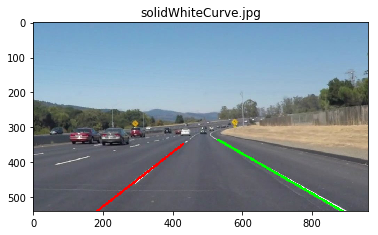

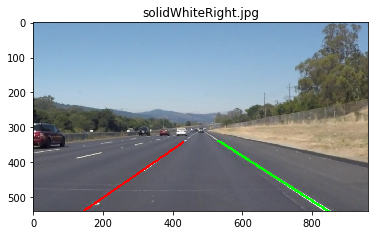

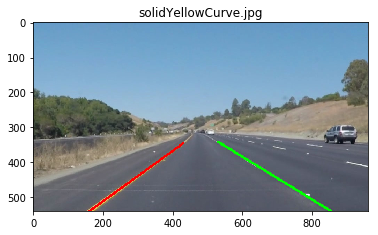

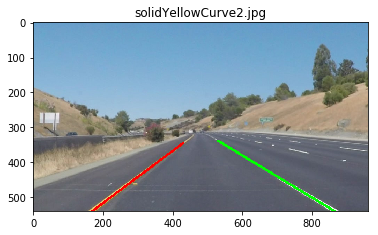

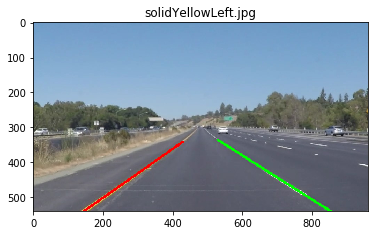

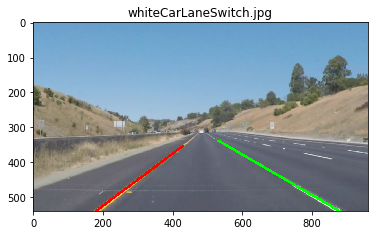

In [22]:
imagenames = os.listdir("test_images/")
for imagename in imagenames:    # process each image in the directory
    fullname = os.path.join('test_images', imagename)
    image = mpimg.imread(fullname)
    procimg = process_image(image,standardvertices)

    # Plot the output image
    plt.figure()
    plt.imshow(procimg)
    plt.title(imagename)

## Test on Videos
Now, let's apply the pipeine to the videos in test_videos directory.  
Before doing so, we will need to define a new region of interest for the challenge movie.  That particular movie has a different movie size, and the imagery includes part of the front hood of the car that we want to remove.

### Region of Interest for challenge.mp4

In [10]:
dx = 180
dy = 100
dxtop = 90
dybot = 60
imx = 1280
imy = 720
challengevertices = np.array([[(dx,imy-dybot),(imx/2-dxtop, imy/2+dy), (imx/2+dxtop, imy/2+dy), (imx-dx,imy-dybot)]], dtype=np.int32)
   

### Now process all the videos in the test_videos directory
This will take about 20 seconds to process all three videos.

In [11]:
videos = os.listdir("test_videos/")
for video in videos:            # process each video in the directory
    vertices = standardvertices    # get the vertices for this vertextype
    if video=='challenge.mp4':      # the challenge video requires a different mask region
        vertices = challengevertices    # get the vertices for this vertextype
    processed_video = os.path.join('test_videos_output', video)
    videoclip = os.path.join('test_videos', video)
    clip1 = VideoFileClip(videoclip)
    processed_clip = clip1.fl_image(lambda image: process_image(image,vertices)) # run the lane lines processor
    get_ipython().run_line_magic('time', 'processed_clip.write_videofile(processed_video, audio=False)')    # save the output


[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:07<00:00, 35.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.72 s, sys: 1.43 s, total: 7.15 s
Wall time: 7.82 s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:03<00:00, 66.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.02 s, sys: 914 ms, total: 3.93 s
Wall time: 3.76 s
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:09<00:00, 68.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.63 s, sys: 2 s, total: 11.6 s
Wall time: 10.3 s


### Show the process videos in HTML

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./test_videos_output/SolidWhiteRight.mp4"))

In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./test_videos_output/SolidYellowLeft.mp4"))

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./test_videos_output/challenge.mp4"))